Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau

In [3]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
!unzip /content/gdrive/MyDrive/CNN_assignment.zip -d /content/gdrive/MyDrive/CNN_assignment/


Archive:  /content/gdrive/MyDrive/CNN_assignment.zip
  inflating: /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating

In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
root_path="/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/"
train_path=root_path+"Train/"
test_path=root_path+"Test/"
data_dir_train = pathlib.Path(train_path)
data_dir_test = pathlib.Path(test_path)

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

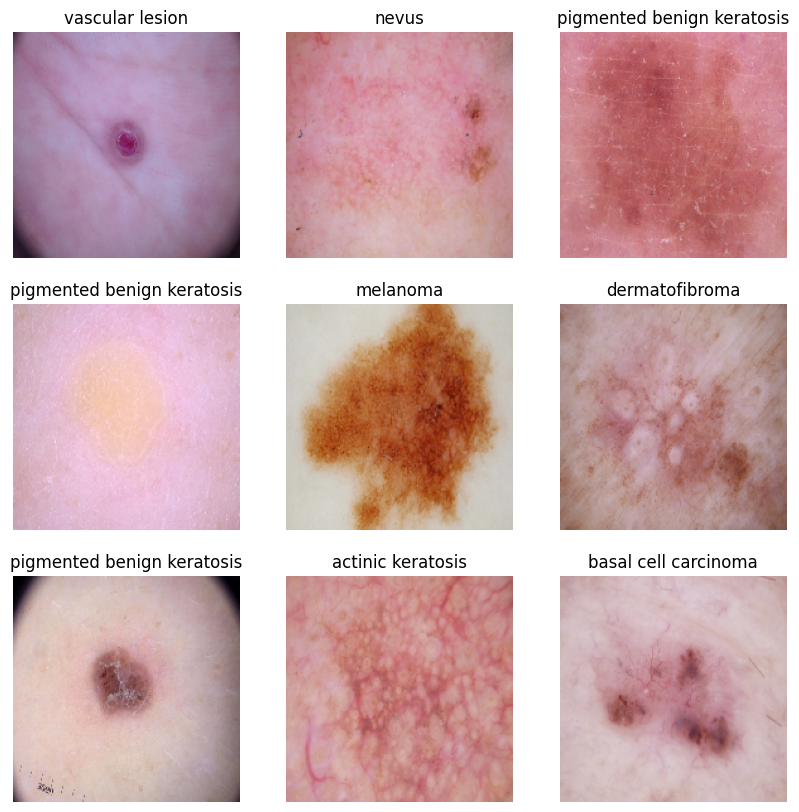

In [11]:
import matplotlib.pyplot as plt
no_of_classes=len(class_names)
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(no_of_classes):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

Creating the model

In [13]:
def getBaseModel(data_augmentation=None):
  padding_val = 'Valid'
  model = Sequential()
  model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))
  #Data Augmentation
  if data_augmentation != None :
    model.add(data_augmentation)
    padding_val = 'Same'
  model.add(layers.Conv2D(32,kernel_size=(3,3),padding = padding_val,activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPool2D(pool_size=(2,2)))
  model.add(layers.Conv2D(64,kernel_size=(3,3),padding = padding_val,activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPool2D(pool_size=(2,2)))
  model.add(layers.Conv2D(128,kernel_size=(3,3),padding = padding_val,activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPool2D(pool_size=(2,2)))
  model.add(layers.Conv2D(256,kernel_size=(11,11),padding = padding_val,activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPool2D(pool_size=(2,2)))
  model.add(layers.Dropout(0.5))
  model.add(layers.Flatten())
  model.add(layers.Dense(256,activation='relu'))
  model.add(layers.Dropout(0.25))
  model.add(layers.Dense(128,activation='relu'))
  model.add(layers.Dropout(0.25))
  model.add(layers.Dense(64,activation='relu'))
  model.add(layers.Dropout(0.25))
  model.add(layers.Dense(32,activation='relu'))
  model.add(layers.Dropout(0.25))
  model.add(layers.Dense(len(class_names),activation='softmax'))
  return model

In [14]:
model1 = getBaseModel()

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [15]:
from keras.optimizers import Adam

In [16]:
def getOptimiser():
 optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
 return optimizer

In [17]:
### Todo, choose an appropirate optimiser and loss function
optimizer = getOptimiser()
model1.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
# View the summary of all layers
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 178, 178, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 87, 87, 64)       2

### Train the model

In [19]:
epochs = 20
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 29s 176ms/step - loss: 2.5600 - accuracy: 0.1987 - val_loss: 2.1846 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 5s 83ms/step - loss: 2.0910 - accuracy: 0.2606 - val_loss: 2.0801 - val_accuracy: 0.2081
Epoch 3/20
56/56 [==============================] - 5s 81ms/step - loss: 1.9379 - accuracy: 0.2952 - val_loss: 2.1125 - val_accuracy: 0.1902
Epoch 4/20
56/56 [==============================] - 5s 83ms/step - loss: 1.8754 - accuracy: 0.3203 - val_loss: 2.1157 - val_accuracy: 0.1544
Epoch 5/20
56/56 [==============================] - 5s 84ms/step - loss: 1.8320 - accuracy: 0.3683 - val_loss: 2.0238 - val_accuracy: 0.2729
Epoch 6/20
56/56 [==============================] - 5s 82ms/step - loss: 1.7772 - accuracy: 0.3560 - val_loss: 1.7754 - val_accuracy: 0.3512
Epoch 7/20
56/56 [==============================] - 5s 81ms/step - loss: 1.7559 - accuracy: 0.3733 - val_loss: 1.9091 - val_accuracy: 0.2931
Epoch 8/20
56/56 [====

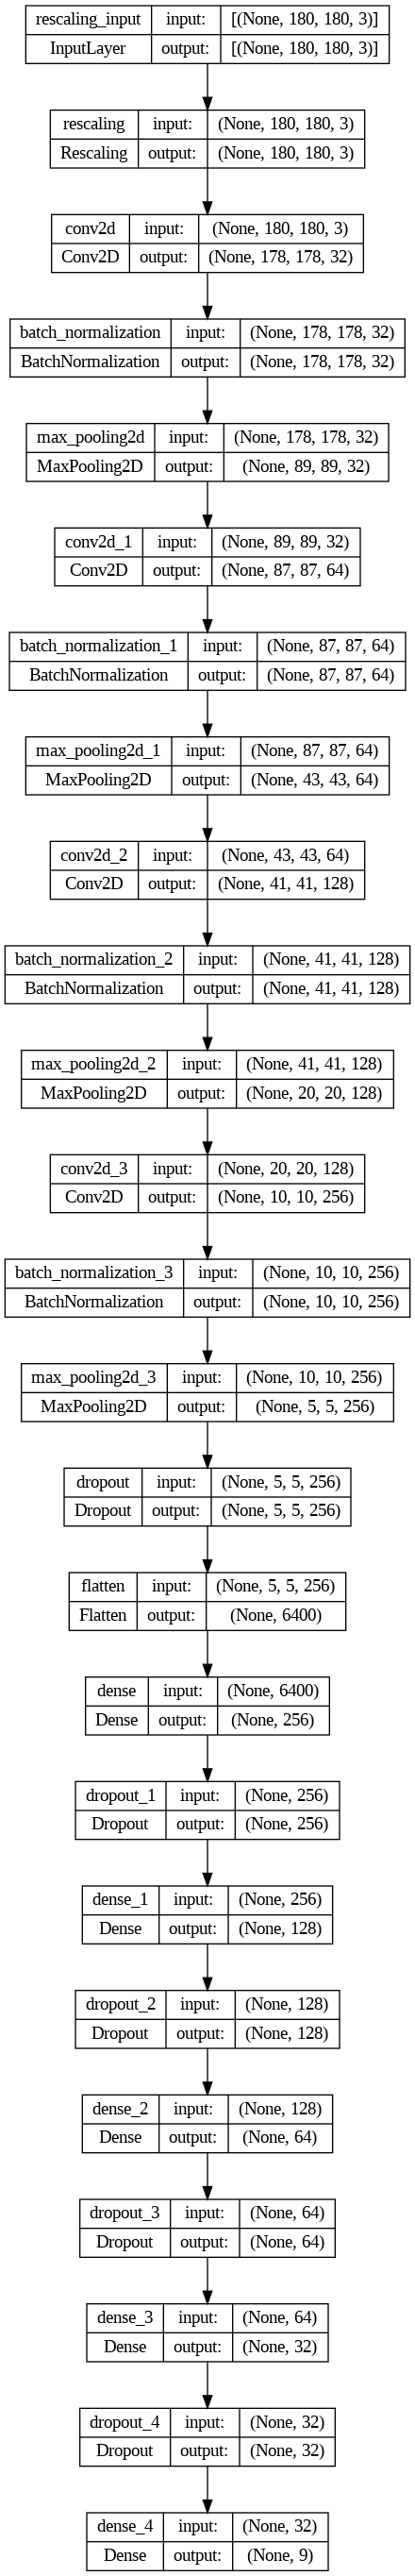

In [20]:
from tensorflow.keras.utils import plot_model
plot_model(model1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Visualizing training results

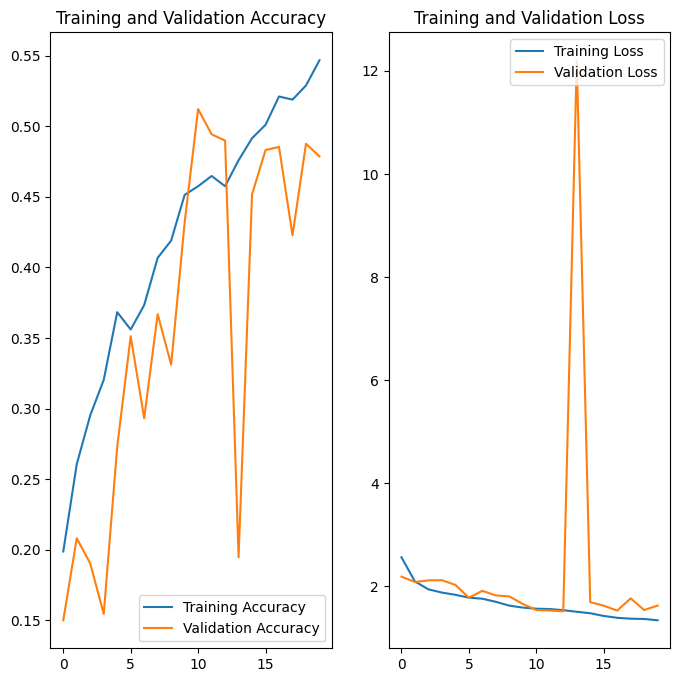

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
loss, accuracy = model1.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model1.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 0s 17ms/step - loss: 1.6232 - accuracy: 0.4787
Accuracy:  0.5200892686843872
Validation Accuracy:  0.4787471890449524
Loss:  1.4236990213394165
Validation Loss 1.6232378482818604


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

Accuracy:  0.520
Validation Accuracy:  0.478

The model is underfitting

### Write your findings here

**Observations**

*   the difference between training accuracy and validation accuracy is not significant but the overall efficiency of the model is quite low
*   The model shows signs of underfitting

Thus we can infer that the model is not meeting expectation of identifying the provided sample correctly. Hence needs to be changed for a better accuracy rate.

**Data Augmentation**

It is a set of techniques to artificially increase the dataset by modifying the copies of existing data or synthetically generating new copies of the dataset by using the existing dataset.

In [23]:
!pip install keras-cv
!pip install keras-core

In [24]:
import keras_cv

Using TensorFlow backend


In [25]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.RandomRotation(0.2),
    layers.RandomContrast(0.2),
    layers.RandomZoom(0.1)
])

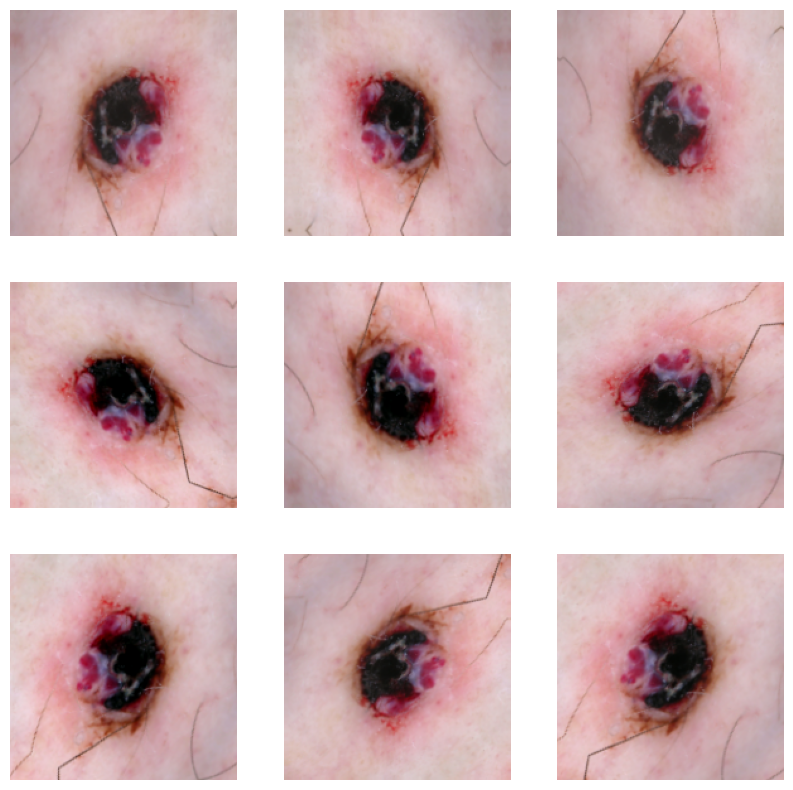

In [26]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(no_of_classes):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [27]:
model2=getBaseModel(data_augmentation)

### Compiling the model

In [28]:
## Your code goes here
optimizer = getOptimiser()
model2.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [29]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_4 (Batc  (None, 180, 180, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 64)       

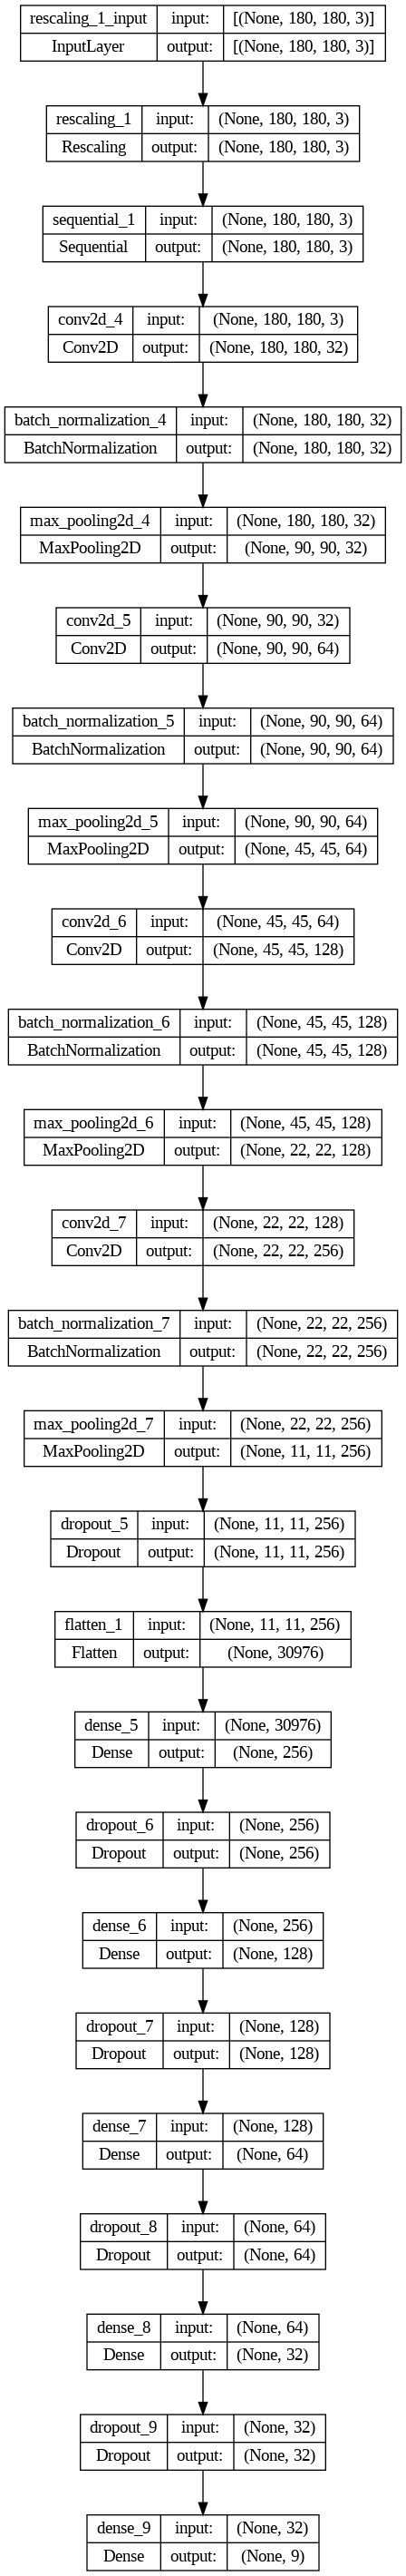

In [30]:
plot_model(model2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Training the model

In [31]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 10s 128ms/step - loss: 3.5242 - accuracy: 0.1674 - val_loss: 2.1499 - val_accuracy: 0.2394
Epoch 2/20
56/56 [==============================] - 6s 110ms/step - loss: 2.2784 - accuracy: 0.1920 - val_loss: 2.0941 - val_accuracy: 0.2170
Epoch 3/20
56/56 [==============================] - 6s 108ms/step - loss: 2.1640 - accuracy: 0.2065 - val_loss: 2.0658 - val_accuracy: 0.2416
Epoch 4/20
56/56 [==============================] - 5s 97ms/step - loss: 2.0485 - accuracy: 0.2556 - val_loss: 2.0940 - val_accuracy: 0.2081
Epoch 5/20
56/56 [==============================] - 5s 97ms/step - loss: 1.9233 - accuracy: 0.2863 - val_loss: 2.2338 - val_accuracy: 0.2058
Epoch 6/20
56/56 [==============================] - 5s 97ms/step - loss: 1.9190 - accuracy: 0.2846 - val_loss: 2.0525 - val_accuracy: 0.2170
Epoch 7/20
56/56 [==============================] - 5s 97ms/step - loss: 1.8584 - accuracy: 0.3036 - val_loss: 2.0037 - val_accuracy: 0.2461
Epoch 8/2

### Visualizing the results

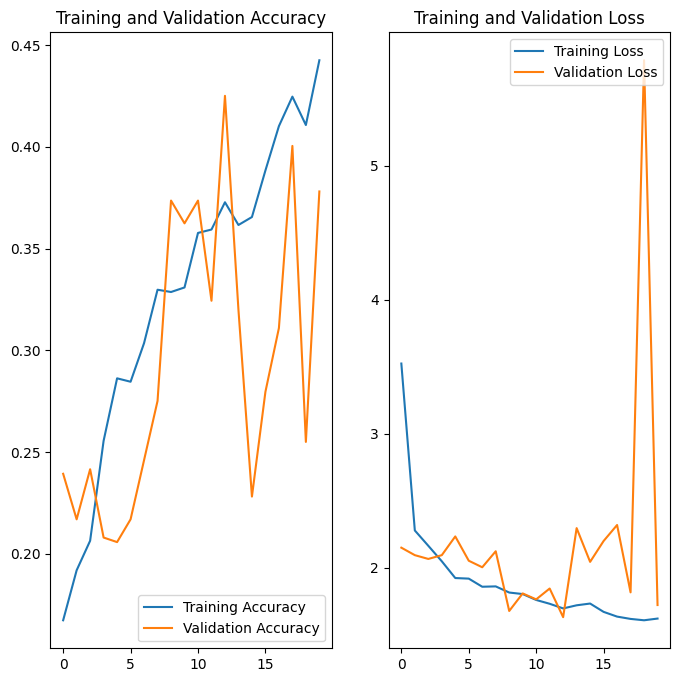

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
loss, accuracy = model2.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model2.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 0s 18ms/step - loss: 1.7218 - accuracy: 0.3781
Accuracy:  0.41015625
Validation Accuracy:  0.37807607650756836
Loss:  1.6815768480300903
Validation Loss 1.721791386604309


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Accuracy:  0.410
Validation Accuracy:  0.378

Performance has further dropped, still not upto the mark

**Observations**

*   It can be observed the accuracy of the model has further dropped.
*   This implies that the model is still underfitting.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

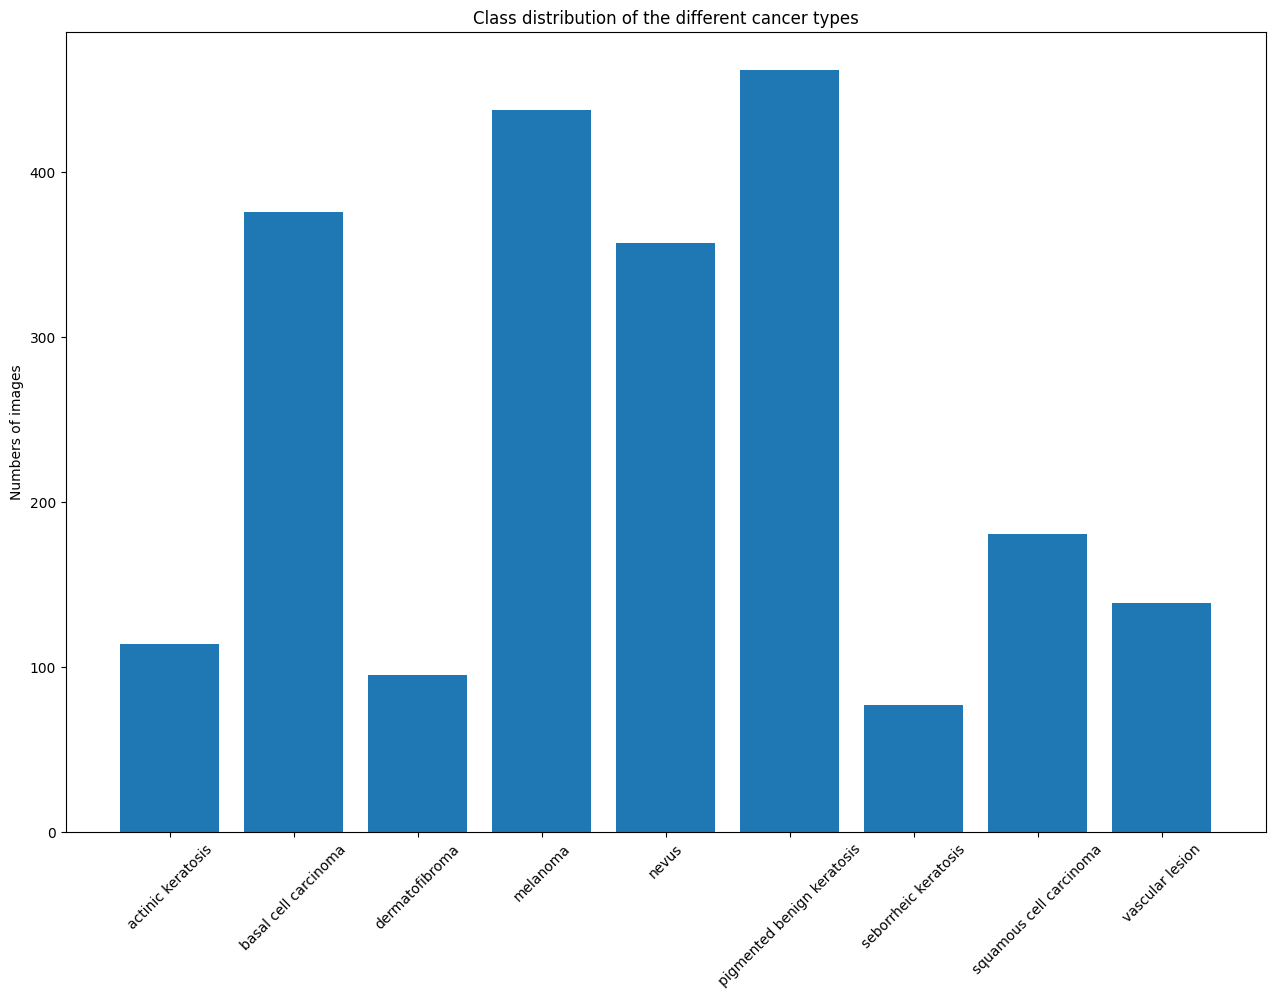

In [34]:
## Your code goes here.
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0,0,1,1])
x=[]
y=[]
for i in range(no_of_classes):
  x.append(class_names[i])
  y.append(len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

ax.bar(x,y)
ax.set_ylabel('Numbers of images')
ax.set_title('Class distribution of the different cancer types')
plt.xticks(rotation=45)
plt.show()

In [35]:
print("Number of samples for each class: ")
for i in range(no_of_classes):
  print(class_names[i],' - ',len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

Number of samples for each class: 
actinic keratosis  -  114
basal cell carcinoma  -  376
dermatofibroma  -  95
melanoma  -  438
nevus  -  357
pigmented benign keratosis  -  462
seborrheic keratosis  -  77
squamous cell carcinoma  -  181
vascular lesion  -  139


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
**Ans : seborrheic keratosis with 77 samples**
#### - Which classes dominate the data in terms proportionate number of samples?
**Ans : pigmented benign keratosis with 462 samples**


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [36]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [37]:
path_to_training_dataset=train_path
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B671341ABF0>: 100%|██████████| 500/500 [00:20<00:00, 23.88 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B6712759840>: 100%|██████████| 500/500 [00:23<00:00, 21.21 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B6713377EB0>: 100%|██████████| 500/500 [00:21<00:00, 23.17 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7B6712C60550>: 100%|██████████| 500/500 [01:36<00:00,  5.18 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7B6712CADB40>: 100%|██████████| 500/500 [01:12<00:00,  6.85 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B67128787F0>: 100%|██████████| 500/500 [00:17<00:00, 28.57 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7B67132F0730>: 100%|██████████| 500/500 [00:40<00:00, 12.21 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B6713370760>: 100%|██████████| 500/500 [00:17<00:00, 29.06 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B67129D59F0>: 100%|██████████| 500/500 [00:16<00:00, 29.78 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [38]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [39]:
from glob import glob

In [40]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026626.jpg_ee09c56c-88cd-400e-8b79-360e4ac212af.jpg',
 '/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032206.jpg_3d7249df-b523-485e-b181-eba93ffa73ee.jpg',
 '/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028941.jpg_7daff481-07e8-4cfb-8801-f451aaa3fcf4.jpg',
 '/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033811.jpg_120ef6fa-dd65-4bb6-94dd-2a267abc87d5.jpg',
 '/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/ac

In [41]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [42]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [43]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [44]:
new_df['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [45]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [46]:
data_dir_train=path_to_training_dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [47]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset =  "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [48]:
## your code goes here

In [49]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [50]:
model3=getBaseModel()

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [51]:
## your code goes here
optimizer = getOptimiser()

model3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=optimizer,
                  metrics=['accuracy'])

#### **Todo:**  Train your model

In [52]:
epochs = 50
## Your code goes here, use 50 epochs.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001)
# your model fit code
history = model3.fit(train_ds,
  epochs = epochs, verbose = 1, validation_data=val_ds , callbacks=[learning_rate_reduction])

Epoch 1/50
169/169 [==============================] - 64s 138ms/step - loss: 2.3376 - accuracy: 0.1827 - val_loss: 2.2621 - val_accuracy: 0.1151 - lr: 0.0010
Epoch 2/50
169/169 [==============================] - 14s 83ms/step - loss: 1.9204 - accuracy: 0.2606 - val_loss: 2.2601 - val_accuracy: 0.1923 - lr: 0.0010
Epoch 3/50
169/169 [==============================] - 14s 85ms/step - loss: 1.7709 - accuracy: 0.3175 - val_loss: 1.7356 - val_accuracy: 0.3519 - lr: 0.0010
Epoch 4/50
169/169 [==============================] - 14s 84ms/step - loss: 1.6897 - accuracy: 0.3416 - val_loss: 2.0472 - val_accuracy: 0.3111 - lr: 0.0010
Epoch 5/50
169/169 [==============================] - 14s 83ms/step - loss: 1.6254 - accuracy: 0.3772 - val_loss: 9.9925 - val_accuracy: 0.2168 - lr: 0.0010
Epoch 6/50
169/169 [==============================] - 15s 86ms/step - loss: 1.5958 - accuracy: 0.3934 - val_loss: 2.2282 - val_accuracy: 0.3578 - lr: 0.0010
Epoch 7/50
169/169 [==============================] - 14s

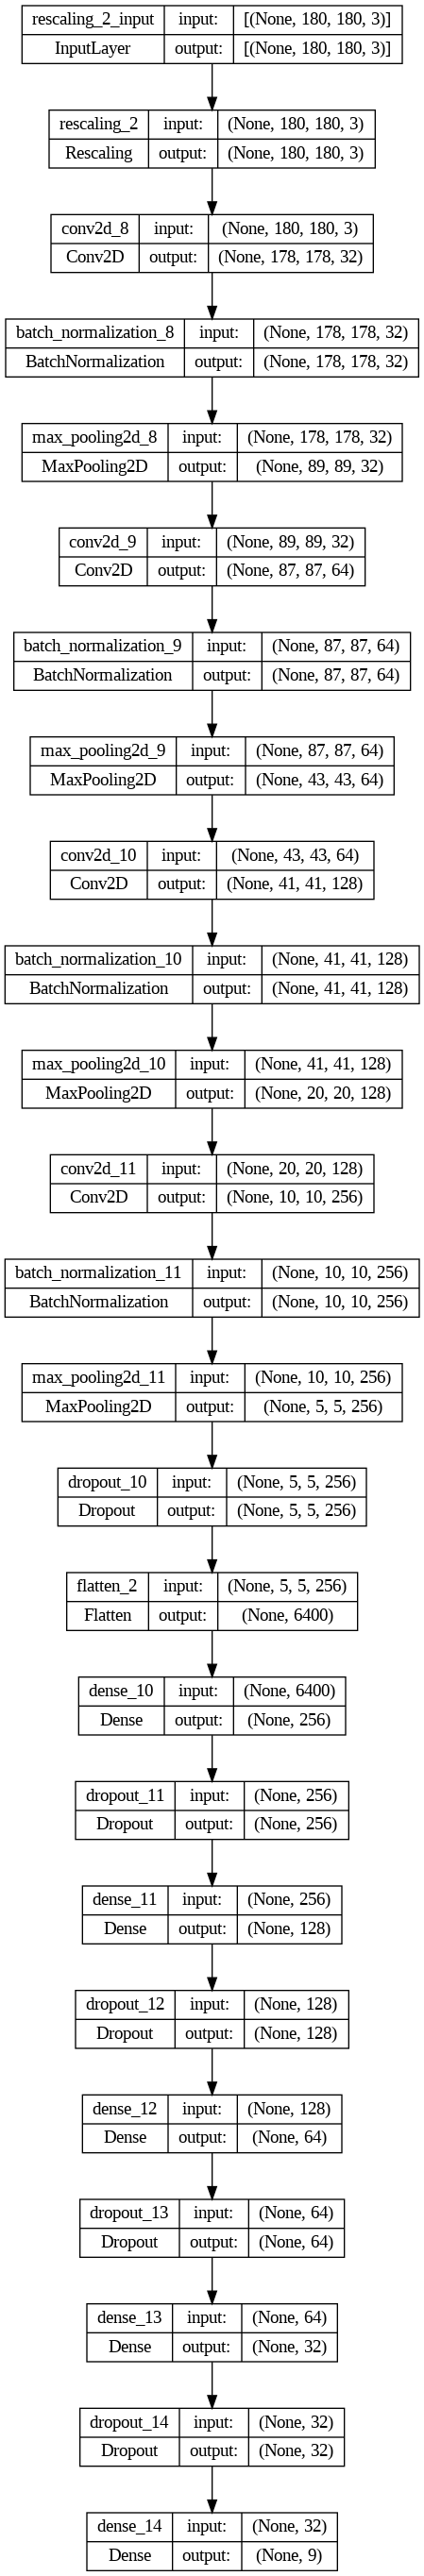

In [53]:
plot_model(model3, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#### **Todo:**  Visualize the model results

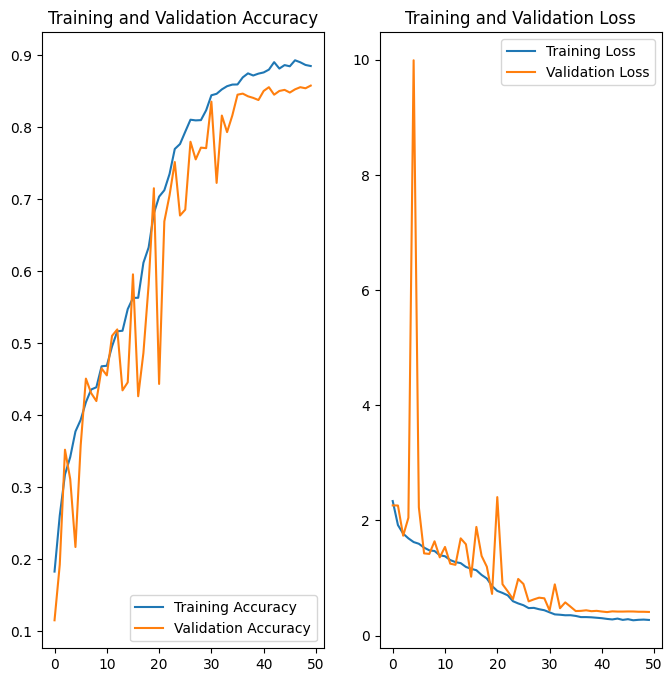

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [55]:
loss, accuracy = model3.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model3.evaluate(val_ds, verbose=1)
print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

43/43 [==============================] - 1s 16ms/step - loss: 0.4115 - accuracy: 0.8575
Accuracy:  0.9170994162559509
Validation Accuracy:  0.8574610352516174
Loss:  0.209938183426857
Validation Loss 0.4115307927131653


#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

Ans : Overall accuracy has improved a lot.


1/1 [==============================] - 0s 328ms/step
Actual Class: actinic keratosis
Predicted Class: actinic keratosis
1/1 [==============================] - 0s 22ms/step
Actual Class: basal cell carcinoma
Predicted Class: squamous cell carcinoma
1/1 [==============================] - 0s 23ms/step
Actual Class: dermatofibroma
Predicted Class: squamous cell carcinoma
1/1 [==============================] - 0s 19ms/step
Actual Class: melanoma
Predicted Class: melanoma
1/1 [==============================] - 0s 19ms/step
Actual Class: nevus
Predicted Class: nevus
1/1 [==============================] - 0s 19ms/step
Actual Class: pigmented benign keratosis
Predicted Class: actinic keratosis
1/1 [==============================] - 0s 20ms/step
Actual Class: seborrheic keratosis
Predicted Class: melanoma
1/1 [==============================] - 0s 22ms/step
Actual Class: squamous cell carcinoma
Predicted Class: squamous cell carcinoma
1/1 [==============================] - 0s 21ms/step
Actual Cla

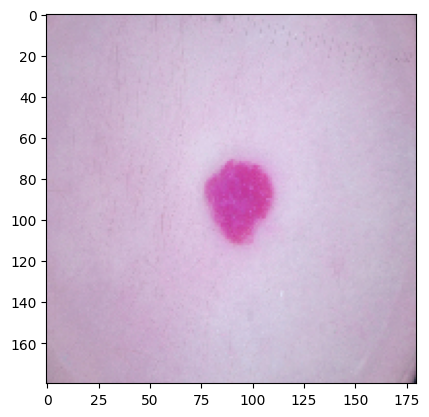

In [56]:
from tensorflow.keras.preprocessing.image import load_img
# Construct the path to a test image
for i in range(no_of_classes):
  classname=class_names[i]
  test_image_path = os.path.join(data_dir_test, classname, '*')

  # Get a list of all test images for the selected class
  test_images = glob(test_image_path)

  # Load the last test image in the list
  test_image = load_img(test_images[-1], target_size=(180, 180, 3))

  # Display the test image
  plt.imshow(test_image)
  plt.grid(False)

  # Expand dimensions to match the input shape of the model
  img = np.expand_dims(test_image, axis=0)

  # Make predictions using the trained model
  pred = model3.predict(img)

  # Get the index of the predicted class with the highest probability
  pred = np.argmax(pred)

  # Get the predicted class name
  pred_class = class_names[pred]

  # Print the actual and predicted class names
  print("Actual Class: " + classname)
  print("Predicted Class: " + pred_class)

In [57]:
!rm -rf /content/gdrive/MyDrive/CNN_assignment/